In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras_nlp
import os
import json

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [10]:
!mkdir -p data
!wget -O "data/cleaned_data.csv" "https://drive.google.com/uc?export=download&id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY"

--2024-11-22 15:05:03--  https://drive.google.com/uc?export=download&id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY
Resolving drive.google.com (drive.google.com)... 142.251.211.238, 2404:6800:4009:806::200e
Connecting to drive.google.com (drive.google.com)|142.251.211.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY&export=download [following]
--2024-11-22 15:05:04--  https://drive.usercontent.google.com/download?id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.192.33, 2a00:1450:400e:810::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.192.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6284823 (6.0M) [application/octet-stream]
Saving to: ‘data/cleaned_data.csv’

data/cleaned_data.c 100%[===================>]   5.99M   880KB/s

In [4]:
with open("data/cleaned_data.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")
    print(f"The third line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

statement,status

The second line (first data point) looks like this:

concerning dream s causing panic im f ocd depression gad figuring bipolar just dream running away cops led guy way older sexwith children even sex stopped midway refused led sex children going set trap get arrested think set trap times lead sex children…… m not sure arrest part just glimpses running police thinking trapping police get thing woke sexually turned time scared guilty anxious wake sexually turned dream children violence forcing guy sex watching leading sex children panicking absolutely panicking issues pocd don t longer bad issue recognize ocd can play different themes makes feel like m hidden monster fuck wake turned disgusting dream feel worst amount guilt dream never dream like s terrifying makes real messing ocd things dream know s dream swear iv never like dream since believe signs m actually p do makes think suicide straight away someone help,Anxiety

The third

In [5]:
VOCAB_SIZE = 10000
MAX_LENGTH = 500
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'
FILENAME = "data/cleaned_data.csv"

In [6]:
sentences = []
labels = []

with open(FILENAME, 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile) 
    for row in reader_obj: 
        labels.append(row[1])
        sentences.append(row[0])

In [7]:
sequence_lengths = [len(sentence.split()) for sentence in sentences]
print("Mean length:", np.mean(sequence_lengths))
print("Median length:", np.median(sequence_lengths))
print("90th percentile:", np.percentile(sequence_lengths, 90))

Mean length: 161.55612244897958
Median length: 140.0
90th percentile: 309.0


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

I0000 00:00:1732374516.446673    1110 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
train_size = int(len(sentences) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = validation_dataset.map(lambda statement, status: statement)
test_labels = validation_dataset.map(lambda statement, status: status)

There are 4860 sentence-label pairs for training.

There are 1216 sentence-label pairs for validation.



In [10]:
# clean memory
del sentences
del labels
del dataset

In [11]:
# comment this code if there's already vocab output file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_statement,
    vocabulary_size=VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='mental_vocab_subwords.txt'
)

# Initialize the subword tokenizer
vectorizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./mental_vocab_subwords.txt'
)

vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

2024-11-23 22:08:50.787096: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary contains 7007 words



In [12]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.
    
    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    
    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)
   
    return label_encoder

In [13]:
# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Suicidal', 'Stress', 'Personality disorder', 'Normal', 'Depression', 'Bipolar', 'Anxiety']


2024-11-23 22:20:47.164473: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  maxlen=MAX_LENGTH, 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [15]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)
test_sequences_subword = test_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels_encoded)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels_encoded)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

Number of batches in the train dataset: 152
Number of batches in the validation dataset: 38


In [16]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 500)
Shape of the validation batch: (32, 500)


2024-11-23 22:21:06.329820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-23 22:21:06.350488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
# Hyperparameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32 
LSTM2_DIM = 8
DENSE_DIM = 64

model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(vectorizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(32, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'] 
) 

In [ ]:
checkpoint_path = '/content/drive/MyDrive'
checkpoint_model_filepath = checkpoint_path+"/checkpoint.weights.h5"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "train_loss": [], "train_accuracy": [], 
                        "val_loss": [], "val_accuracy": []}
        
        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)
        
        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            with open(self.epoch_file, 'w') as f:
                f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch + 1))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch + 1)
        self.history["train_loss"].append(logs.get("loss"))
        self.history["train_accuracy"].append(logs.get("accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_accuracy"].append(logs.get("val_accuracy"))
        
        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)
        
custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [44]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 64)       │       448,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,903 (1.71 MB)

 Trainable params: 448,903 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
example_batch = train_dataset_final.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-11-23 22:26:40.537393: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
I0000 00:00:1732375601.135454    3938 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-23 22:26:42.462646: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


predictions have shape: (32, 7)


In [77]:
num_of_epoch = 20

In [78]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

Resuming training from epoch 11
Loaded weights from content/drive/MyDrive/checkpoint.weights.h5


/home/ryanfikri/anaconda3/envs/capstone-project/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [79]:
history = model.fit(
    train_dataset_final, 
    epochs=num_of_epoch - start_epoch, 
    validation_data=test_dataset_final,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback
    ]
    )

Epoch 1/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8879 - loss: 0.3931 - val_accuracy: 0.7410 - val_loss: 0.6579
Epoch 2/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9070 - loss: 0.3541 - val_accuracy: 0.7434 - val_loss: 0.6515
Epoch 3/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9152 - loss: 0.3201 - val_accuracy: 0.7484 - val_loss: 0.6478
Epoch 4/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9256 - loss: 0.2890 - val_accuracy: 0.7475 - val_loss: 0.6468
Epoch 5/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2606 - val_accuracy: 0.7492 - val_loss: 0.6471
Epoch 6/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9449 - loss: 0.2349 - val_accuracy: 0.7467 - val_loss: 0.6489
Epoch 7/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9559 - loss: 0.2114 - val_accuracy: 0.7434 - val_loss: 0.6515
Epoch 8/9
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 0.1903 - val_accuracy: 0.7410 - v

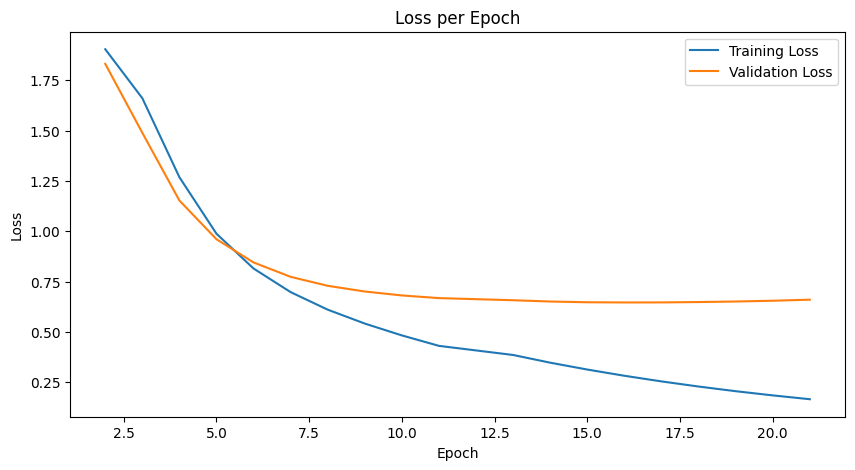

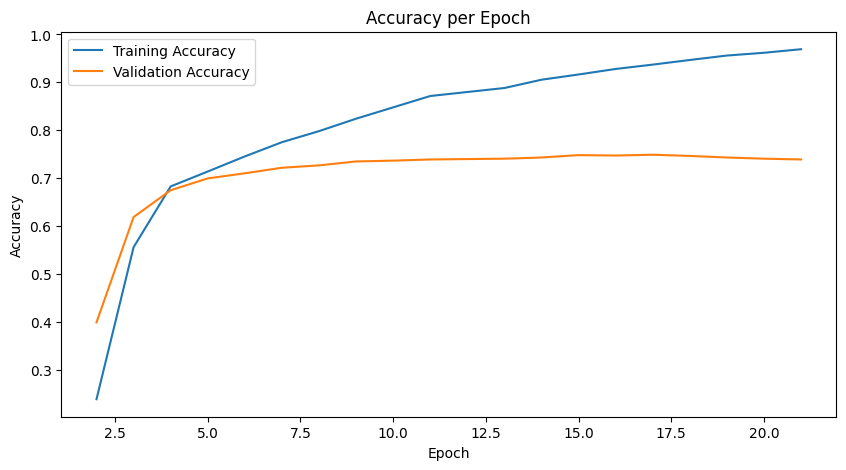

In [86]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
plot_graphs(training_log_filepath)

In [37]:
# Get the vocabulary
imdb_vocab_fullword = vectorizer.get_vocabulary()

# Define sample sentence
sample_string = "i cant take it anymore"

# Encode using the plain text tokenizer
tokenized_string = vectorizer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [ 10 972 211  10 376 236]
The original string: i cant take i ##t anymore


In [39]:
rawtext_test = ["i'm really nervous"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(vectorizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  10    1   14  167 1009]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 ...
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]], shape=(500, 5), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[[6.4393879e-10 2.4529444e-03 1.4956758e-05 ... 4.7807954e-04
  6.0836724e-03 9.9067527e-01]
 [9.5139257e-17 2.2604352e-05 4.0135580e-01 ... 3.9916940e-06
  3.8936027e-04 5.9822822e-01]
 [9.5139257e-17 2.2604352e-05 4.0135580e-01 ... 3.9916940e-06
  3.8936027e-04 5.9822822e-01]
 ...
 [9.5139257e-17 2.2604352e-05 4.0135580e-01 ... 3.9916940e-06
  3.8936027e-04 5.9822822e-01]
 [9.5139257e-17 2.2604352e-05 4.0135580e-01 ... 3.9916940e-06
  3.8936027e-04 5.9822822e-01]
 [9.5139257e-17 2.2604352e-05 4.0135580e-01 ... 3.9916940e-06
  3.8936027e-04 5.9822822e-01]]
Predicted class: Anxiety


2024-11-22 15:30:35.190970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Run this if you happy with the model
with open("label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save('second_iteration.keras')